In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 13

# For motion in 2D Cartesian coordinates

In [2]:
x_arr = np.linspace(-5,5,31)
y_arr = np.linspace(-5,5,21)

x_mesh, y_mesh = np.meshgrid(x_arr, y_arr, indexing='ij')

mesh_shape = x_mesh.shape

spatial_dimenion = 2
vec_mesh_shape = mesh_shape + (spatial_dimenion,)

In [3]:
from numpy import sin, cos

vx0 = 0.1
def xs_f(t): return vx0 * t
def vxs_f(t): return vx0 * np.ones_like(t)

omega0 = 0.5
def ys_f(t): return (t > 0.) * sin(omega0*t)
def vys_f(t): return (t > 0.) * omega0 * cos(omega0*t)

In [4]:
t_arr = np.linspace(-5, 10, 21)

In [5]:
from matplotlib.patches import Rectangle

Text(0, 0.5, 'y / $y_{0}$')

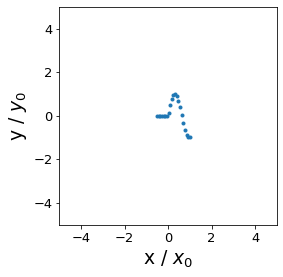

In [6]:
fig, ax = plt.subplots()
ax.plot(xs_f(t_arr), ys_f(t_arr), '.')
# rect = Rectangle((x_arr[0], y_arr[0]), x_arr[-1]-x_arr[0], y_arr[-1]-y_arr[0], facecolor='none', edgecolor='black')
# ax.add_patch(rect)
ax.set_aspect('equal')
ax.set_xlim(x_arr[[0,-1]]), ax.set_ylim(y_arr[[0,-1]])
ax.set_xlabel("x / $x_{0}$", fontsize='x-large')
ax.set_ylabel(r"y / $y_{0}$", fontsize='x-large')

In [7]:
from numpy import sqrt
def retarded_time_eq(tau, t, x, y, xs, ys):
    return sqrt((x-xs(t-tau))**2 + (y - ys(t-tau))**2)

In [8]:
t_index = -1
t_arr[t_index]

10.0

In [9]:
from scipy.optimize import fixed_point

tau_mesh = np.empty(mesh_shape)
for i, j in np.ndindex(*tau_mesh.shape):
    tau_mesh[i,j] = fixed_point(retarded_time_eq, x0=0., args=(t_arr[t_index], x_arr[i], y_arr[j], xs_f, ys_f))

tr_mesh = t_arr[t_index] - tau_mesh

In [10]:
xs_tr_mesh = xs_f(tr_mesh)
ys_tr_mesh = ys_f(tr_mesh)

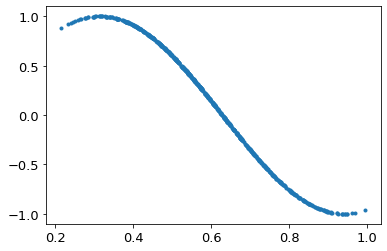

In [11]:
fig, ax = plt.subplots()

ax.plot(xs_tr_mesh.ravel(), ys_tr_mesh.ravel(), '.')

In [12]:
R_vec_mesh = np.empty(vec_mesh_shape)

R_vec_mesh[...,0] = x_mesh - xs_tr_mesh
R_vec_mesh[...,1] = y_mesh - ys_tr_mesh

In [13]:
R_mesh = np.linalg.norm(R_vec_mesh, axis=-1)
# R_mesh = sqrt((x_mesh - xs_tr_mesh)**2 + (y_mesh - ys_tr_mesh)**2)

In [14]:
vs_vec_mesh = np.empty(vec_mesh_shape)
vs_vec_mesh[...,0] = vxs_f(tr_mesh)
vs_vec_mesh[...,1] = vys_f(tr_mesh)

In [15]:
R_dot_v_mesh = np.sum(R_vec_mesh * vs_vec_mesh, axis=-1)

In [16]:
temp_mesh = R_mesh - R_dot_v_mesh
temp_mesh[temp_mesh==0] = temp_mesh[temp_mesh!=0].min()
R_minus_R_dot_v_mesh_regulated = temp_mesh
phi_mesh = 1./ R_minus_R_dot_v_mesh_regulated

#### Visualize the scalar potential $\Phi(\mathbf{x},t)$

In [17]:
phi_lower_val, phi_upper_val = np.quantile(phi_mesh, [0.001, 0.99]) 
# phi_mesh

phi_lower_val, phi_upper_val

(0.10525217330063102, 1.6698927736493963)

In [18]:
from matplotlib.colors import LogNorm, Normalize

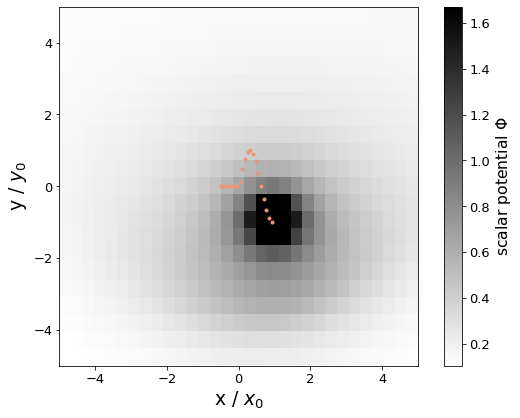

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

img = ax.imshow(phi_mesh.transpose(), extent=(*x_arr[[0,-1]], *y_arr[[0,-1]]), 
                aspect='equal', origin='lower', norm=Normalize(phi_lower_val, phi_upper_val), cmap='binary')
cb = fig.colorbar(img, ax=ax)

# ax.plot(xs_f(t_arr[t_index]), ys_f(t_arr[t_index]), 'x', color='white')
ax.plot(xs_f(t_arr[:t_index]), ys_f(t_arr[:t_index]), '.', color='darksalmon')

cb.set_label(r"scalar potential $\Phi$", fontsize='large')
ax.set_xlabel("x / $x_{0}$", fontsize='x-large')
ax.set_ylabel(r"y / $y_{0}$", fontsize='x-large')
fig.tight_layout()
# fig.savefig("xy-scalar-potential-test-2.png")

# For a linear motion

In [ ]:
v0 = 0.1
def z_s(t):
    return v0 * t
def z_dot_s(t):
    return v0 * np.ones_like(t)

In [ ]:
rho_arr = np.linspace(0,1,11)
z_arr = np.linspace(-1,1,21)

rho_mesh, z_mesh = np.meshgrid(rho_arr, z_arr, indexing='ij')

In [ ]:
from numpy import sqrt
def retarded_time_eq(tau, t, rho, z, z_s):
    return sqrt(rho**2 + (z - z_s(t-tau))**2)

In [ ]:
t_arr = np.linspace(0, 5, 11)
t_index = -1

In [ ]:
z_s(t_arr[t_index])

In [ ]:
from scipy.optimize import fixed_point

tau_mesh = np.empty((rho_arr.size, z_arr.size))
for i, j in np.ndindex(rho_arr.size, z_arr.size):
    tau_mesh[i,j] = fixed_point(retarded_time_eq, x0=0., args=(t_arr[t_index], rho_arr[i], z_arr[j], z_s))

In [ ]:
tr_mesh = t_arr[t_index] - tau_mesh

In [ ]:
R_mesh = sqrt(rho_mesh**2 + (z_mesh - z_s(tr_mesh))**2)

In [ ]:
R_mesh_regulated = R_mesh.copy()
R_mesh_regulated[R_mesh == 0] = np.min(R_mesh[R_mesh!=0])

In [ ]:
one_over_R_mesh = 1./ R_mesh_regulated

In [ ]:
R_dot_v_mesh = (z_mesh - z_s(tr_mesh)) * z_dot_s(tr_mesh)

In [ ]:
temp_mesh = R_mesh - R_dot_v_mesh
temp_mesh[temp_mesh==0] = temp_mesh[temp_mesh!=0].min()
phi_mesh = 1./temp_mesh

# phi_mesh = one_over_R_mesh

In [ ]:
phi_lower_val, phi_upper_val = np.quantile(phi_mesh, [0.01, 0.99]) 
# phi_mesh

phi_lower_val, phi_upper_val

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
img = ax.imshow(phi_mesh, extent=(*z_arr[[0,-1]], *rho_arr[[0,-1]]), 
                aspect='equal', origin='lower', vmin=phi_lower_val, vmax=phi_upper_val, cmap='binary')
cb = fig.colorbar(img, ax=ax)
cb.set_label(r"scalar potential $\Phi$", fontsize='large')
ax.set_xlabel("z / $x_{0}$", fontsize='x-large')
ax.set_ylabel(r"$\rho$ / $x_{0}$", fontsize='x-large')
fig.tight_layout()
# fig.savefig("scalar-potential-test-2.png")

# For a generic movement in 3D

In [ ]:
from numpy import asarray
def r_s(t):
    _t = asarray(t)
    _shape = (3,)
    if _t.ndim > 0: _shape = _t.shape + _shape
    
    _r_s = np.empty(_shape, dtype=float)
    _r_s[...,0] = 0.
    _r_s[...,1] = 0.
    _r_s[...,2] = 0.
    
    return _r_s